# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks  import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical
import time
import os

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

Mounted at /content/gdrive


# Input data

In [ ]:
%cd /content/gdrive/MyDrive/introToFADS/ue3

/content/gdrive/MyDrive/introToFADS/ue3


In [ ]:
# Loading the training data
PATH = os.getcwd()
# Define data path
train_data_dir = PATH + '/400x/train'
test_data_dir = PATH + '/400x/test'
im_rows=224
im_cols=224
epochs=24
batch_size=32
num_of_train_samples=1458
num_of_test_samples=366
train_datagen=ImageDataGenerator(rescale=1./255, zoom_range=2, rotation_range=90, horizontal_flip=True, vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
train_batch = train_datagen.flow_from_directory(train_data_dir, target_size=(im_rows,im_cols), color_mode="rgb", batch_size=batch_size, class_mode="categorical", classes=['benign', 'malignant'], shuffle=True, seed=42)
test_batch = test_datagen.flow_from_directory(test_data_dir, target_size=(im_rows,im_cols), color_mode="rgb", batch_size=1, class_mode="categorical", classes=['benign', 'malignant'], shuffle=False, seed=42)
test_filenames= test_batch.filenames
nb_samples=len(test_filenames)

Found 1456 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


# Build model

In [ ]:
NAME = "assignment_3_CNN"

model = Sequential()
 
model.add(Conv2D(32, (3, 3), input_shape=(im_rows,im_cols,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

 
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten()) 

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

# Train

In [ ]:
tensorboard = TensorBoard(log_dir=PATH + '/logs/{}'.format(NAME))
#learning rate reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=1e-7)
#Checkpoint
filepath=PATH + '/weights_3_2.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

In [ ]:
history=model.fit(train_batch,
          validation_data=test_batch,       
          steps_per_epoch=num_of_train_samples//batch_size,
          epochs=epochs, validation_steps=num_of_test_samples//batch_size+1, callbacks=[learn_control, checkpoint, tensorboard])

import json
with open(PATH + '/history.json', 'w') as f:
  json.dump(str(history.history), f)

Epoch 1/24
 1/45 [..............................] - ETA: 0s - loss: 0.7513 - accuracy: 0.3438WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - ETA: 0s - loss: 0.7194 - accuracy: 0.6692
Epoch 00001: val_accuracy improved from -inf to 0.08333, saving model to /content/gdrive/MyDrive/introToFADS/ue3/weights_3_2.best.hdf5
45/45 [==============================] - 331s 7s/step - loss: 0.7194 - accuracy: 0.6692 - val_loss: 0.8355 - val_accuracy: 0.0833
Epoch 2/24
45/45 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8097
Epoch 00002: val_accuracy improved from 0.08333 to 1.00000, saving model to /content/gdrive/MyDrive/introToFADS/ue3/weights_3_2.best.hdf5
45/45 [==============================] - 130s 3s/

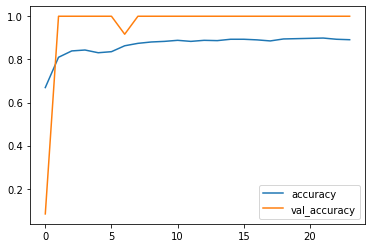

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

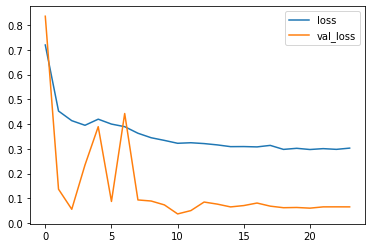

In [ ]:
history_df=pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.load_weights(filepath)

# Confusion Matrix and Classification Report

In [ ]:
Y_test_pred=model.predict_generator(test_batch, steps=nb_samples)
y_test_pred=np.argmax(Y_test_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Confusion matrix, without normalization
[[ 79  39]
 [ 48 198]]
              precision    recall  f1-score   support

      benign       0.62      0.67      0.64       118
   malignant       0.84      0.80      0.82       246

    accuracy                           0.76       364
   macro avg       0.73      0.74      0.73       364
weighted avg       0.77      0.76      0.76       364



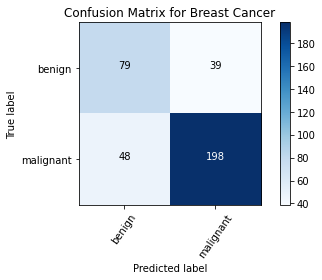

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_batch.classes, y_test_pred)
labels =['benign', 'malignant']
plot_confusion_matrix(cm, labels, title ='Confusion Matrix for Breast Cancer')
print(classification_report(test_batch.classes, y_test_pred, target_names=labels))

AUC value is 0.74


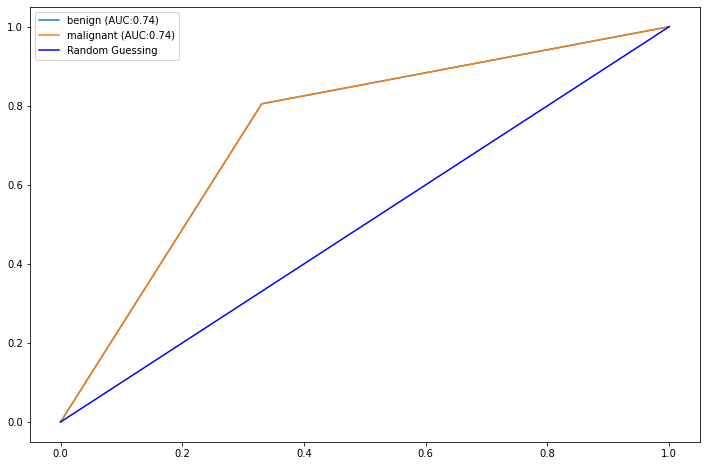

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    for (idx, c_label) in enumerate(labels): # labels: ['benign', 'malignant']
        fpr, tpr, thresholds = roc_curve(y_test[:].astype(int), y_pred[:])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)

print('AUC value is %0.2f' % multiclass_roc_auc_score(test_batch.classes, y_test_pred))